Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.


In [50]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import requests
import copy

from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [29]:
# Carpeta de imágenes
#images = [cv.imread(file) for file in list_images('/home/franklin/PVDefectDetect/TestsPV-vision/examples/crack_segmentation/img_for_prediction')]
#images = [cv.imread(file) for file in list_images('/home/franklin/PVDefectDetect/Test_crack')]
#image_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/CeldasIndividuales/Mono2_V40_I5_t28'
#images = [cv.imread(file) for file in list_images(image_path)]
#transformers = Compose([FixResize(256), ToTensor(), Normalize()])

root = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells'
val_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/images'
val_annotations = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/annotations'

images_val = [cv.imread(file) for file in list_images(val_path)]
ann_val = [cv.imread(file) for file in list_images(val_annotations)]

# Verificar que las imágenes se cargaron correctamente
#print(f'Número de imágenes: {len(images)}')
print(f'Número de imágenes de validación: {len(images_val)}')
print(f'Número de anotaciones de validación: {len(ann_val)}')

#valset = SolarDataset(root, image_folder="images", mask_folder="annotations", transforms=transformers)


Número de imágenes de validación: 155
Número de anotaciones de validación: 155


El siguiente código define una clase `myDataset` que hereda de la clase `Dataset` de PyTorch. Esta clase se utiliza para cargar y transformar las imágenes que se pasarán al modelo. La transformación se aplica a cada imagen cuando se accede a ella, no todas a la vez al principio. Esto es más eficiente en términos de memoria, especialmente cuando se trabaja con conjuntos de datos grandes.

In [51]:
# Definir una clase personalizada que hereda de Dataset
class MyDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, annotations, transform=None):
        # Guardar las imágenes, anotaciones y la transformación como atributos de la instancia
        self.images = images
        self.annotations = annotations
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Obtener la imagen y la anotación correspondiente por índice
        image = self.images[idx]
        annotation = self.annotations[idx]

        # Redimensionar la imagen y la anotación al tamaño deseado
        image = cv.resize(image, (256, 256))
        annotation = cv.resize(annotation, (256, 256))

        # Convertir la anotación a escala de grises si tiene más de un canal
        if annotation.ndim > 2:
            annotation = cv.cvtColor(annotation, cv.COLOR_BGR2GRAY)

        # Aplicar la transformación si se especificó
        if self.transform:
            image = self.transform(image)
            # Para las anotaciones, solo convertimos a tensor sin normalizar
            annotation = F.to_tensor(annotation)

        # Devolver la imagen y la anotación transformadas
        return image, annotation

El siguiente código define una transformación que se aplica a las imágenes antes de pasarlas al modelo. La transformación consta de dos pasos: convertir la imagen a un tensor de PyTorch y normalizar los valores de los píxeles. Luego, se crea una instancia de la clase `myDataset` que se utiliza para cargar y transformar las imágenes.

In [52]:
# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Crear una instancia de la clase myDataset. Esta clase es un tipo personalizado de Dataset que se utiliza para cargar y transformar las imágenes.
# La lista de imágenes y la transformación compuesta se pasan como argumentos al inicializar el conjunto de datos.
#imgset = myDataset(images, transform)
imgset_val = MyDataset(images_val, transform)
annset_val = MyDataset(ann_val, transform)

In [53]:
# Definir la transformación de las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear una instancia de la clase MyDataset con las imágenes y anotaciones de validación
valset = MyDataset(images_val, ann_val, transform)

In [54]:
# Carpeta de pesos del modelo

#weight_path = '/home/franklin/supervisely/neural network weights/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'
weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'

In [55]:
# Definir el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se utilizará. De lo contrario, se utilizará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')

# Crear una instancia del modelo U-Net con 5 canales de salida. 
# El número de canales de salida generalmente corresponde al número de clases que el modelo está diseñado para predecir.
unet = construct_unet(5)

# Envolver el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

criterion = CrossEntropyLoss()
optimizer = Adam(unet.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

Dispositivo: cuda:0


Este código anterior define el dispositivo en el que se ejecutará el modelo (GPU si está disponible, de lo contrario CPU), crea una instancia del modelo U-Net, y luego envuelve el modelo en un objeto `DataParallel` para permitir la ejecución en paralelo en múltiples GPUs.

In [ ]:
# Inicializar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar. En este caso, es la instancia de U-Net que se ha creado anteriormente.
    model=unet,
    # El conjunto de datos que se utilizará para las pruebas. En este caso, es el conjunto de imágenes que se ha cargado y transformado anteriormente.
    #test_dataset=imgset,
    val_dataset=valset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    #predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo. En este caso, es el dispositivo que hemos definido anteriormente (GPU si está disponible, de lo contrario CPU).
    device=device,
    # El directorio donde se guardarán los resultados. En este caso, los resultados se guardarán en un directorio llamado 'output'.
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_cell_prediction'
)

# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)



El código anterior inicializa un objeto `ModelHandler` que se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados. Luego, carga los pesos del modelo desde un archivo especificado.

In [59]:
modelhandler = ModelHandler(
    model=unet,
    train_dataset=valset,
    val_dataset=valset,
    test_dataset=valset,
    predict_only=False,
    batch_size_train=32,
    batch_size_val=32,
    lr_scheduler=lr_scheduler,
    num_epochs=10,
    criterion=criterion,
    optimizer=optimizer,
    #test_dataset=mi_dataset_prueba,
    device=device,
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_cell_prediction'
)
modelhandler.load_model(weight_path)

In [ ]:
targets_squeezed =  # Esto elimina la dimensión 1, cambiando las dimensiones a [32, 256, 256]

# Ahora puedes llamar a test_model() para evaluar
# Nota: Debes implementar test_model() en tu clase ModelHandler si aún no está implementado.
_ = modelhandler.test_model()

In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [18]:

# Carpeta de imágenes
#val_imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/images'
val_imgs_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/img'

# Carpeta de anotaciones
#val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/annotations'
val_annotations_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/ann'
images_val = [cv.imread(file) for file in list_images(val_imgs_path)]           #imágenes de validación
ann_val = [cv.imread(file) for file in list_images(val_annotations_path)]       # anotaciones de validación
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes de validación: {len(images_val)}')
print(f'Número de anotaciones de validación: {len(ann_val)}')

# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# La lista de imágenes y la transformación compuesta se pasan como argumentos al inicializar el conjunto de datos.
imgset = myDataset(images_val, transform)

# Carpeta de pesos del modelo
weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'

# Definir el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se utilizará. De lo contrario, se utilizará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')
# Crear una instancia del modelo U-Net con 5 canales de salida. 
# El número de canales de salida generalmente corresponde al número de clases que el modelo está diseñado para predecir.
unet = construct_unet(5)
# Envolver el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

# model = unet
# model.load_state_dict(torch.load(weight_path))
# model.eval()    # Establecer el modelo en modo de evaluación

# Inicializar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar. En este caso, es la instancia de U-Net que se ha creado anteriormente.
    model=unet,
    # El conjunto de datos que se utilizará para las pruebas. En este caso, es el conjunto de imágenes que se ha cargado y transformado anteriormente.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo. En este caso, es el dispositivo que hemos definido anteriormente (GPU si está disponible, de lo contrario CPU).
    device=device,
    # El directorio donde se guardarán los resultados. En este caso, los resultados se guardarán en un directorio llamado 'output'.
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_cell_prediction'
)

# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)

# Ejecutar el modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)
# Se definió una transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])

# Se definió un mapa de colores para las diferentes clases de máscaras.
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

# Se definió una función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)

# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)

Número de imágenes de validación: 206
Número de anotaciones de validación: 206
Dispositivo: cuda:0


100%|██████████| 103/103 [01:51<00:00,  1.08s/it]


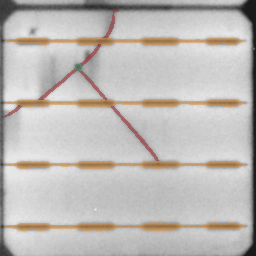

In [19]:
# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images_val[100], masks_each[100])

In [45]:
# Función para convertir las anotaciones de validación en máscaras booleanas 
# de la misma manera que `get_masks` procesa las predicciones del modelo.
def get_annotation_masks(annotations):
    masks_each = []
    for annotation in annotations:
        annotation = cv.resize(annotation, (256, 256))  # Redimensionar anotación al tamaño de las predicciones
        busbar = (annotation == 4) #4
        crack = (annotation == 3) #3
        cross = (annotation == 2) #2
        dark = (annotation == 1)  #1
        # cross = (annotation == 1)
        # busbar = (annotation == 2)
        # crack = (annotation == 3)
        # dark = (annotation == 4)
        # Convertir las máscaras de NumPy a tensores de PyTorch y apilarlas.
        masks_tensor = torch.stack([torch.from_numpy(busbar.astype(np.float32)), 
                                    torch.from_numpy(crack.astype(np.float32)), 
                                    torch.from_numpy(cross.astype(np.float32)), 
                                    torch.from_numpy(dark.astype(np.float32))])
        masks_each.append(masks_tensor)
        #masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return torch.stack(masks_each)




In [43]:
# Calcular el IoU para una clase específica
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    if union == 0:
        return float('nan')  # Si no hay ningún píxel verdadero o predicho en esta clase, devolver NaN
    return intersection / union

# Función para calcular Precision
def calculate_precision(pred_mask, true_mask):
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    predicted_positive = pred_mask.sum().item()
    if predicted_positive == 0:
        return float('nan')  # Si no hay ningún píxel predicho positivo, devolver NaN
    return true_positive / predicted_positive

# Función para calcular Recall
def calculate_recall(pred_mask, true_mask):
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    actual_positive = true_mask.sum().item()
    if actual_positive == 0:
        return float('nan')  # Si no hay ningún píxel verdadero positivo, devolver NaN
    return true_positive / actual_positive

# Función para calcular F1 Score
def calculate_f1_score(precision, recall):
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        return float('nan')  # Si alguna de las métricas es NaN o la suma es 0, devolver NaN
    return 2 * (precision * recall) / (precision + recall)

# Función para evaluar las predicciones y calcular todas las métricas
def evaluate_predictions(pred_masks, true_masks):
    ious = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    precisions = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    recalls = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    f1_scores = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        for i, class_name in enumerate(['busbar', 'crack', 'cross', 'dark']):
            iou = calculate_iou(pred_mask[i], true_mask[i])
            precision = calculate_precision(pred_mask[i], true_mask[i])
            recall = calculate_recall(pred_mask[i], true_mask[i])
            f1_score = calculate_f1_score(precision, recall)
            
            ious[class_name].append(iou)
            precisions[class_name].append(precision)
            recalls[class_name].append(recall)
            f1_scores[class_name].append(f1_score)
    
    metrics = {}
    for class_name in ious:
        metrics[class_name] = {
            'IoU': np.nanmean(ious[class_name]),
            'Precision': np.nanmean(precisions[class_name]),
            'Recall': np.nanmean(recalls[class_name]),
            'F1 Score': np.nanmean(f1_scores[class_name])
        }
    return metrics

# Convertir las anotaciones a tensores de imágenes para ser usadas por la función get_annotation_masks
annval = [np.array(Image.open(img_path).convert("L")) for img_path in list_images(val_annotations_path)]

# Obtener las máscaras de las anotaciones de validación.
true_masks = get_annotation_masks(annval)

# Calcular las métricas para las predicciones del modelo.
metrics = evaluate_predictions(masks_each, true_masks)

print("Métricas para las predicciones del modelo:")

for class_name, class_metrics in metrics.items():
    print(f'{class_name}:')
    for metric_name, value in class_metrics.items():
        print(f'  {metric_name}: {value:.4f}')


Métricas para las predicciones del modelo:
busbar:
  IoU: 0.8424
  Precision: 0.8591
  Recall: 0.9777
  F1 Score: 0.9134
crack:
  IoU: 0.1805
  Precision: 0.6659
  Recall: 0.2367
  F1 Score: 0.6387
cross:
  IoU: 0.0486
  Precision: 0.7092
  Recall: 0.0515
  F1 Score: 0.3026
dark:
  IoU: 0.1178
  Precision: 0.7716
  Recall: 0.1252
  F1 Score: 0.6853


In [ ]:

def visualize_comparison(images, predicted_masks, true_masks, index):
	"""
	Visualiza la comparación entre la máscara predicha y la máscara de las anotaciones.
	
	:param images: Lista de imágenes originales.
	:param predicted_masks: Máscaras predichas por el modelo.
	:param true_masks: Máscaras de las anotaciones.
	:param index: Índice de la imagen a visualizar.
	"""
	# Obtener la imagen original, la máscara predicha y la máscara de anotación
	original_img = images[index]
	predicted_mask = predicted_masks[index]
	true_mask = true_masks[index]
	
	# Configurar la figura para la visualización
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	
	# Mostrar la imagen original
	axs[0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
	axs[0].set_title('Imagen Original')
	axs[0].axis('off')
	
	# Mostrar la máscara predicha
	predicted_mask_vis = draw_mask(original_img, predicted_mask)
	axs[1].imshow(predicted_mask_vis)
	axs[1].set_title('Máscara Predicha')
	axs[1].axis('off')
	
	# Mostrar la máscara de anotación
	true_mask_vis = draw_mask(original_img, true_mask)
	axs[2].imshow(true_mask_vis)
	axs[2].set_title('Máscara de Anotación')
	axs[2].axis('off')
	
	plt.show()

# Ejemplo de visualización para la primera imagen
visualize_comparison(images_val, masks_each, true_masks, 100)

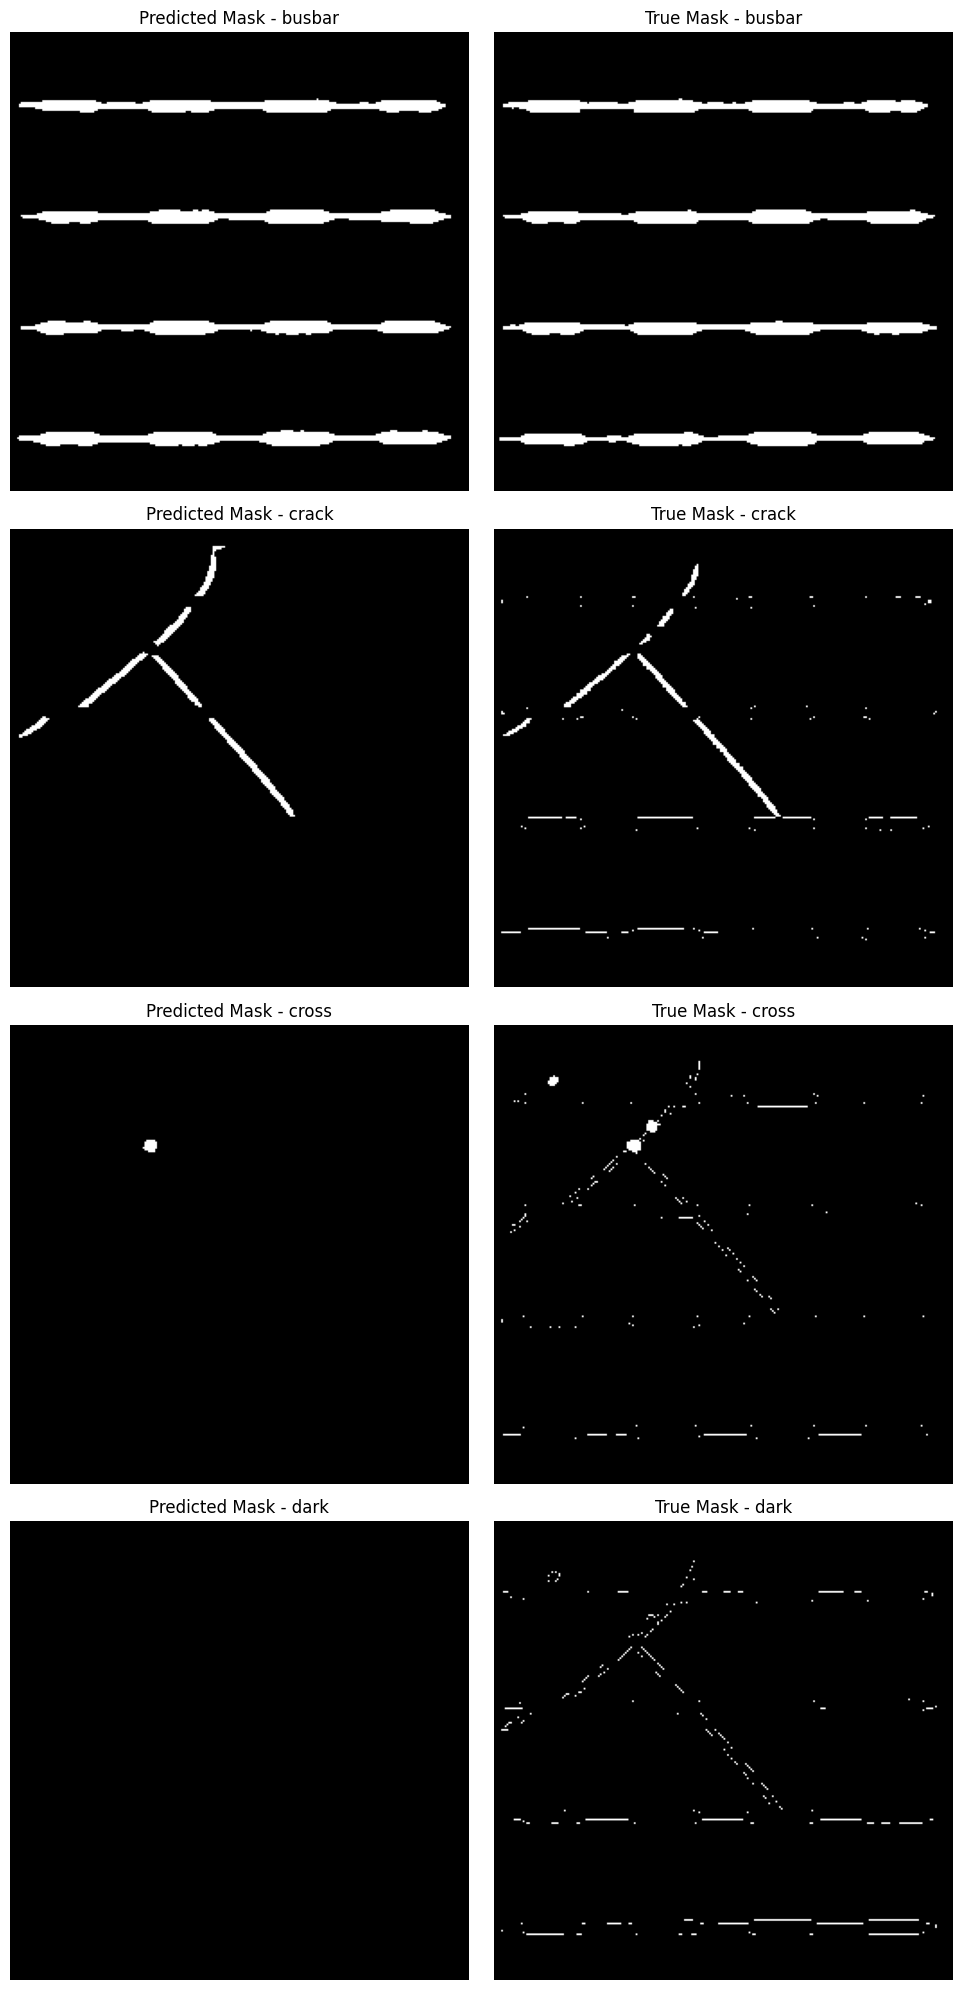

In [44]:

def show_comparison(pred_mask, true_mask, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, num_classes * 5))
    
    for i, class_name in enumerate(class_names):
        # Predicted mask for the class
        axes[i, 0].imshow(pred_mask[i], cmap='gray')
        axes[i, 0].set_title(f'Predicted Mask - {class_name}')
        axes[i, 0].axis('off')
        
        # True mask for the class
        axes[i, 1].imshow(true_mask[i], cmap='gray')
        axes[i, 1].set_title(f'True Mask - {class_name}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# Supongamos que tienes una predicción y una máscara verdadera para comparar:
pred_mask = masks_each[100]  # Primera predicción del modelo
true_mask = true_masks[100]  # Primera máscara de anotación

# Nombres de las clases
class_names = ['busbar', 'crack', 'cross', 'dark']

# Mostrar la comparación
show_comparison(pred_mask, true_mask, class_names)
